# TVE Preprocessing

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import osmnx as ox
import rasterio
import multiprocessing as mp
import json

from pathlib import Path
from rasterio.plot import show

%matplotlib inline

In [5]:
data_path = Path(".").resolve().parent / "vina_del_mar"
tsunami_scenario = "tsunami_1985"
epsg = "epsg:32719"
urban_mask = gpd.read_file(data_path / "urban" / "urban_mask.shp").to_crs(epsg)
vertical_evacuation_mask = gpd.read_file(data_path / "urban" / "vertical_evacuation_mask.shp").to_crs(epsg)
sidewalks = pd.read_excel(data_path / "urban" / "sidewalks.xlsx")
shelters_raw = gpd.read_file(data_path / "shelters" / "shelters_raw.shp").to_crs(epsg)
elevation_filepath = data_path / "urban" / "urban_elevation.asc"
elevation = rasterio.open(elevation_filepath)

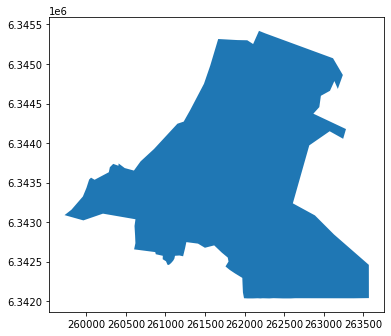

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
urban_mask.to_crs(epsg).plot(ax=ax)
fig.show()

## Urban Network

In [7]:
G = ox.graph_from_polygon(
    urban_mask.to_crs("epsg:4326").unary_union,
    network_type="walk",
    simplify=False
)
G = ox.project_graph(G, to_crs=elevation.crs)
ox.add_node_elevations_raster(
    G,
    elevation_filepath,
    band=1
)
ox.elevation.add_edge_grades(G, add_absolute=False, precision=3)
G = ox.project_graph(G, to_crs=epsg)
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

## Evacuation Routes

In [8]:
def euclidean_dist(a, b, G=G):
    x1 = G.nodes[a]["x"]
    y1 = G.nodes[a]["y"]
    x2 = G.nodes[b]["x"]
    y2 =  G.nodes[b]["y"]
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def get_evacuation_route(G, origin, targets, weight="weight", mode="best", heuristic=None):
    paths = {target: nx.astar_path(G, origin, target, heuristic, weight) for target in targets}
    lengths = {target: sum(ox.utils_graph.get_route_edge_attributes(G, path, weight)) for target, path in paths.items()}
    if mode == "best":
        best_target = min(lengths, key=lengths.get)
        route = paths[best_target][1:]
        if len(route) == 0:
            route = [origin]
    elif mode == "all":
        route = {}
        for target, path in paths.items():
            target_route = path[1:]
            if len(target_route) == 0:
                target_route = [origin]
            route[target] = target_route
    else:
        print("You should select mode best or all.")
    return (origin, route)


def get_evacuation_routes_parallel(args, cpus=None):
    pool = mp.Pool(cpus)
    sma = pool.starmap_async(get_evacuation_route, args)
    evacuation_routes = sma.get()
    pool.close()
    pool.join()
    return {origin: route for origin, route in evacuation_routes}

In [9]:
horizontal_shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[lambda x: x["evac_type"] == "horizontal", "geometry"].x.values,
    Y=shelters_raw.loc[lambda x: x["evac_type"] == "horizontal", "geometry"].y.values
)
horizontal_args = ((G, origin, horizontal_shelter_nodes_id, "length", "best", None) for origin in G.nodes)
horizontal_evacuation_routes = get_evacuation_routes_parallel(horizontal_args)

In [10]:
vertical_shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[lambda x: x["evac_type"] == "vertical", "geometry"].x.values,
    Y=shelters_raw.loc[lambda x: x["evac_type"] == "vertical", "geometry"].y.values
)
vertical_args = ((G, origin, vertical_shelter_nodes_id, "length", "best", None) for origin in G.nodes)
vertical_evacuation_routes = get_evacuation_routes_parallel(vertical_args)

In [11]:
alternative_args = (
    (
        G,
        origin,
        [shelter for shelter in vertical_shelter_nodes_id if origin != shelter],
        "length",
        "all",
        None
    ) for origin in vertical_shelter_nodes_id
)
# alternative_evacuation_routes = get_evacuation_routes_parallel(alternative_args)
alternative_evacuation_routes = {}
for origin, routes_dict in get_evacuation_routes_parallel(alternative_args).items():
    for shelter, route in routes_dict.items():
        alternative_evacuation_routes[f"{origin}&{shelter}"] = route

In [12]:
shelter_nodes_id = ox.distance.nearest_nodes(
    G,
    X=shelters_raw.loc[:, "geometry"].x.values,
    Y=shelters_raw.loc[:, "geometry"].y.values
)

## Tsunami Inundation

In [13]:
tsunami_inundation_path = Path(data_path / "tsunami_inundation" / tsunami_scenario )
tsunami_seconds = [int(file.stem) for file in tsunami_inundation_path.glob("*.asc")]
seconds_per_tick = int(np.gcd.reduce(tsunami_seconds))
max_seconds = int(max(tsunami_seconds))
tsunami_sample = rasterio.open( tsunami_inundation_path / "0.asc")
cellsize = int(tsunami_sample.res[0])

In [14]:
tsunami_max_flow_depths = np.array([])
tsunami_min_flow_depths = np.array([])
for file in tsunami_inundation_path.glob("*.asc"):
    tsunami_raster = rasterio.open(file).read(1).ravel()
    tsunami_max_flow_depths = np.append(
        tsunami_max_flow_depths,
        tsunami_raster.max()
    )
    tsunami_min_flow_depths = np.append(
        tsunami_min_flow_depths,
        np.where(tsunami_raster > 0, tsunami_raster, np.inf).min()
    )
max_flow_depth = tsunami_max_flow_depths.max()
min_flow_depth = tsunami_min_flow_depths.min()

## Write outputs

In [15]:
urban_nodes = (
    nodes.reset_index()
    .rename(columns={"osmid": "id"})
    .loc[: ,["id", "x", "y", "geometry"]]
)
urban_nodes.head()

,id,x,y,geometry
0,252673360,261684.380267,6.343328e+06,POINT (261684.380 6343327.859)
1,253107884,261682.925030,6.343318e+06,POINT (261682.925 6343318.491)
2,9579427509,261689.944367,6.343327e+06,POINT (261689.944 6343327.017)
3,302967549,261674.223281,6.343329e+06,POINT (261674.223 6343329.199)
4,9579427507,261685.214585,6.343334e+06,POINT (261685.215 6343333.539)


In [16]:
urban_network = (
    edges.reset_index()
    .rename(
        columns={
            "osmid": "id",
            "u": "from_id",
            "v": "to_id",
            "grade": "slope",
        }
    )
    .assign(
        weight=lambda x: x["length"],
        sidewalks=2
    )
    .merge(
        sidewalks,
        how="left"
    )
    .loc[
        :,
        [
            "id",
            "from_id",
            "to_id",
            "length",
            "slope",
            "weight",
            "sidewalks",
            "sd_width",
            "geometry"

        ]
    ]
)
urban_network.head()

,id,from_id,to_id,length,slope,weight,sidewalks,sd_width,geometry
0,242043349,252673360,253107884,9.501,-0.002,9.501,2,3,"LINESTRING (261684.380 6343327.859, 261682.925..."
1,288368027,252673360,9579427509,5.615,0.000,5.615,2,3,"LINESTRING (261684.380 6343327.859, 261689.944..."
2,452081060,252673360,302967549,10.221,-0.001,10.221,2,3,"LINESTRING (261684.380 6343327.859, 261674.223..."
3,551701500,252673360,9579427507,5.753,0.002,5.753,2,3,"LINESTRING (261684.380 6343327.859, 261685.215..."
4,23927111,253107884,9579427512,4.696,-0.002,4.696,2,3,"LINESTRING (261682.925 6343318.491, 261682.290..."


In [17]:
shelters_node = (
    pd.DataFrame(
        {
            "id": shelter_nodes_id,
            "evac_type": shelters_raw.loc[:, "evac_type"].values,
            "capacity": shelters_raw.loc[:, "capacity"].values
        }
    )
    .merge(urban_nodes, how="inner")
    .loc[
        :,
        ["id", "x", "y", "evac_type", "capacity", "geometry"]
    ]
    .pipe(lambda x: gpd.GeoDataFrame(x))
)
shelters_node.head()

,id,x,y,evac_type,capacity,geometry
0,253420305,262103.206679,6.345100e+06,horizontal,1000000,POINT (262103.207 6345099.608)
1,259837542,262544.721003,6.344990e+06,horizontal,1000000,POINT (262544.721 6344989.748)
2,256030204,262774.658589,6.344788e+06,horizontal,1000000,POINT (262774.659 6344788.015)
3,274465691,262956.721877,6.344166e+06,horizontal,1000000,POINT (262956.722 6344165.567)
4,254373577,260146.664181,6.343125e+06,horizontal,1000000,POINT (260146.664 6343124.537)


In [18]:
if "vert_evac" not in vertical_evacuation_mask.columns:
    vertical_evacuation_mask = vertical_evacuation_mask.assign(vert_evac=True)
vertical_evacuation_mask.head()

,Id,vert_evac,geometry
0,0,1,"POLYGON ((260684.716 6343750.884, 260928.927 6..."


In [19]:
urban_nodes.to_file(data_path / "urban"/ "urban_nodes.shp")
urban_network.to_file(data_path / "urban"/ "urban_network.shp")
shelters_node.to_file(data_path / "shelters"/ "shelters_node.shp")
vertical_evacuation_mask.to_file(data_path / "urban" / "vertical_evacuation_mask.shp")

In [20]:
(data_path / "evacuation_routes" / "shortest").mkdir(parents=True, exist_ok=True)
with (data_path / "evacuation_routes" / "shortest" / "horizontal_evacuation_routes.json").open("w") as f:
    json.dump(horizontal_evacuation_routes, f)

with (data_path / "evacuation_routes" / "shortest" / "vertical_evacuation_routes.json").open("w") as f:
    json.dump(vertical_evacuation_routes, f)

with (data_path / "evacuation_routes" / "shortest" / "alternative_evacuation_routes.json").open("w") as f:
    json.dump(alternative_evacuation_routes, f)


In [21]:
with open(tsunami_inundation_path / "config.json", "w") as outfile:
    json.dump(
        {
            "seconds_per_tick": seconds_per_tick,
            "max_seconds": max_seconds,
            "min_flow_depth": min_flow_depth,
            "max_flow_depth": max_flow_depth,
            "cellsize": cellsize
        },
        outfile
    )